In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.ndimage.filters import gaussian_filter
from scipy.fftpack import fft
import scipy
import seaborn as sns
import svcmodel

In [4]:
import sklearn.svm as svm
import sklearn.linear_model as lm

In [5]:
import sklearn.preprocessing as pproc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import normalize

from imblearn.over_sampling import RandomOverSampler

In [6]:
# import the dataset
data_train = pd.read_csv('exoTrain.csv')
data_test = pd.read_csv('exoTest.csv')

In [7]:
#permute the dataset
data_train = np.random.permutation(np.asarray(data_train))
data_test = np.random.permutation(np.asarray(data_test))

In [8]:
#get the Label column and delate the class column and rescale
y1 = data_train[:,0]
y2 = data_test[:,0]

y_train = (y1-min(y1))/(max(y1)-min(y1))
y_test = (y2-min(y2))/(max(y2)-min(y2))

data_train = np.delete(data_train,1,1)
data_test = np.delete(data_test,1,1)

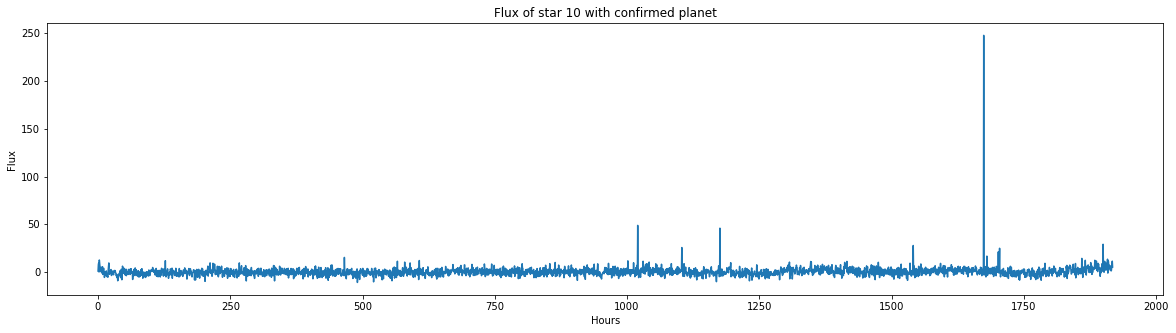

In [9]:
#print the light curve
time = np.arange(len(data_train[0])) * (36/60)  # time in hours

plt.figure(figsize=(20,5))
plt.title('Flux of star 10 with confirmed planet')
plt.ylabel('Flux')
plt.xlabel('Hours')
plt.plot( time , data_train[10] )     #change the number to plot what you want

In [10]:
#normalized data
data_train_norm = normalize(data_train)
data_test_norm = normalize(data_test)

In [11]:
# function to apply gaussian filter to all data
def gauss_filter(dataset,sigma):
    
    dts = []
    
    for x in range(dataset.shape[0]):
        dts.append(gaussian_filter(dataset[x], sigma))
    
    return np.asarray(dts)

In [12]:
# apply the gaussian filter to all rows data
data_train_gaussian = gauss_filter(data_train_norm,7.0)
data_test_gaussian = gauss_filter(data_test_norm,7.0)

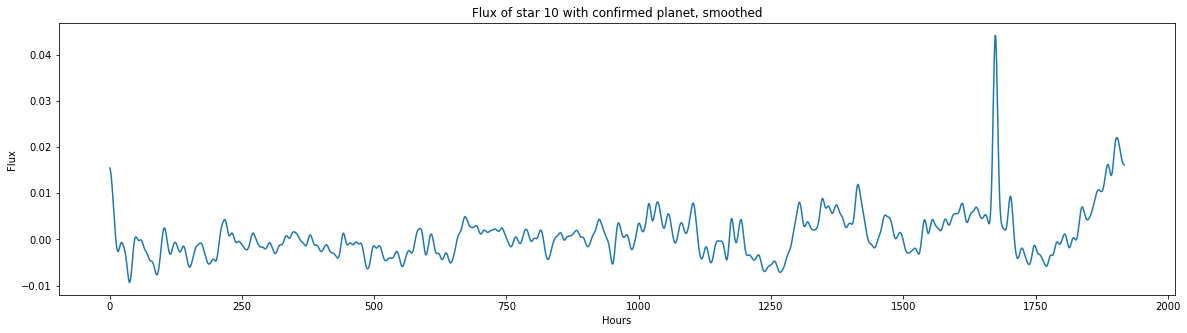

In [21]:
#print the light curves smoothed
plt.figure(figsize=(20,5))
plt.title('Flux of star 10 with confirmed planet, smoothed')
plt.ylabel('Flux')
plt.xlabel('Hours')
plt.plot( time , data_train_gaussian[10])

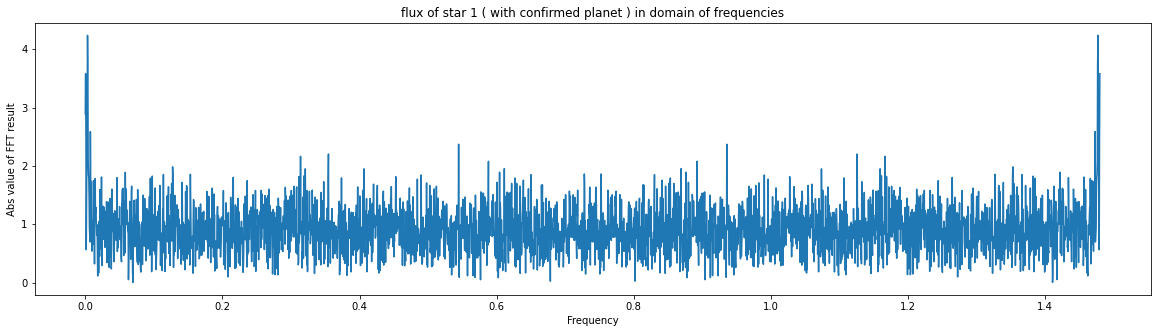

In [20]:
# apply FFT to the data smoothed
frequency = np.arange(len(data_train[0])) * (1/(36.0*60.0))

data_train_fft1 = scipy.fft.fft2(data_train_norm, axes=1)
data_test_fft1 = scipy.fft.fft2(data_test_norm, axes=1)

data_train_fft = np.abs(data_train_fft1)   #calculate the abs value
data_test_fft = np.abs(data_test_fft1)



#get the length of the FFT data, make something here below in order to make the sequences of the same size
# only if they have differet dimensions

len_seq = len(data_train_fft[0])



#plot the FFT of the signals
plt.figure(figsize=(20,5))
plt.title('flux of star 1 ( with confirmed planet ) in domain of frequencies')
plt.ylabel('Abs value of FFT result')
plt.xlabel('Frequency')
plt.plot( frequency, data_train_fft[10] )

In [15]:
#oversampling technique to the data
rm = RandomOverSampler(sampling_strategy=0.5)
data_train_ovs, y_train_ovs = rm.fit_sample( data_train_fft, y_train)



#recap dataset after oversampling
print("After oversampling, counts of label '1': {}".format(sum(y_train_ovs==1)))
print("After oversampling, counts of label '0': {}".format(sum(y_train_ovs==0)))

data_train_ovs = np.asarray(data_train_ovs)
data_test_fft = np.asarray(data_test_fft)

After oversampling, counts of label '1': 2525
After oversampling, counts of label '0': 5050


                         precision    recall  f1-score   support

 NO exoplanet confirmed       0.99      1.00      1.00       565
YES exoplanet confirmed       0.50      0.20      0.29         5

               accuracy                           0.99       570
              macro avg       0.75      0.60      0.64       570
           weighted avg       0.99      0.99      0.99       570

Wall time: 3min 41s


<AxesSubplot:>

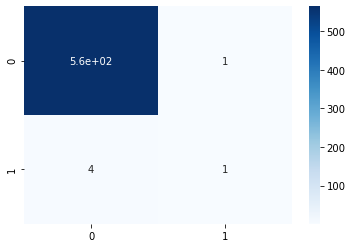

In [16]:
%%time
#create SVC model, predict and plot the results
SVC = svcmodel.SVC_model()
SVC.fit(data_train_ovs, y_train_ovs)

y_pred_svc = SVC.predict(data_test_fft)


print(classification_report(y_test, y_pred_svc, target_names=["NO exoplanet confirmed","YES exoplanet confirmed"]))


conf_matrix = confusion_matrix([int(x) for x in y_test ], [int(y) for y in y_pred_svc ])
sns.heatmap(conf_matrix, annot=True, cmap='Blues')


In [17]:
print(conf_matrix)

[[564   1]
 [  4   1]]


In [19]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred_svc)
print("accuracy : ", accuracy)


accuracy :  0.9912280701754386
